In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

---
### importing data

In [3]:
# Dynamic LDA, K=30, dataset=all 
run_id = 1040
dts = DocTopic.objects.filter(run_id=run_id)

In [4]:
# total score of all DocTopics in run 1040 
dts.aggregate(
    n = Sum('score')
)

{'n': 5541434.19997849}

In [5]:
# total score of DocTopics, sorted by topic in run 1040, 
list(dts.values('topic__title').annotate(
    n = Sum('score')
).order_by('-n'))

[{'n': 1321422.09672952, 'topic__title': '{herr, kolleg, sag}'},
 {'n': 721115.211920929, 'topic__title': '{herr, mehr, sag}'},
 {'n': 314705.728488344, 'topic__title': '{wirtschaft, neu, unternehm}'},
 {'n': 306860.172521163, 'topic__title': '{polit, deutsch, land}'},
 {'n': 211403.5239222, 'topic__title': '{bundesregier, frag, staatssekretar}'},
 {'n': 211322.878740412, 'topic__title': '{euro, steu, milliard}'},
 {'n': 203062.968823193, 'topic__title': '{ausschuss, drucksach, berat}'},
 {'n': 201171.24716961, 'topic__title': '{million, milliard, bund}'},
 {'n': 190536.094146494, 'topic__title': '{forschung, energi, technologi}'},
 {'n': 173939.917586367, 'topic__title': '{steinkohl, kohl, bergbau}'},
 {'n': 172889.836816228,
  'topic__title': '{international, entwicklungsland, konferenz}'},
 {'n': 154281.547869585, 'topic__title': '{strom, energi, prozent}'},
 {'n': 142649.454868036, 'topic__title': '{deutsch, deutschland, amerikan}'},
 {'n': 119016.178699237,
  'topic__title': '{umw

In [6]:
dts_list = list(dts.values('ut__document__parlperiod__n').annotate(
    n = Sum('score')
))

In [7]:
df_dts_list = pd.DataFrame(dts_list)
df_dts_list.columns = ['DocTopic_score', 'parlperiod']
df_dts_list.set_index('parlperiod')

,DocTopic_score
parlperiod,
1,485258.0
2,399660.5
3,236316.5
4,208181.9
5,425223.2
6,164192.8
7,349895.4
8,535199.9
9,187399.3


---

### Overall DocTopic score - Time plot

**test topics**: steinkohl, umweltschutz, international, forschung, saar 

In [8]:
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))

<QuerySet [{'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 1, 'n': 47087.0929253714}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 2, 'n': 38007.6348161008}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 3, 'n': 5346.16989180252}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 4, 'n': 4369.78634736928}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 5, 'n': 3028.07857791149}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 6, 'n': 1178.45381414926}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 7, 'n': 1882.12558428758}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 8, 'n': 2219.53310811508}, {'topic__title': '{antrag, gesetz, ausschuss}', 'ut__document__parlperiod__n': 9, 'n': 403.986846485967}, {'topic__title': '{antrag, gesetz, 

In [9]:
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))

df = pd.DataFrame.from_dict(list(topic_period_scores.filter(Q(topic__title__contains='umweltschutz')|Q(topic__title__contains='steinkohl')|Q(topic__title__contains='international')|Q(topic__title__contains='forschung')|Q(topic__title__contains='saarland'))))

In [10]:
# DocTopic scores for test topics in run 1040
# sorted by parliamentary period 

topics = ['steinkohl', 'umweltschutz', 'international', 'forschung', 'saarland']

tlist = []
for i in topics:
    tlist.append(list(topic_period_scores.filter(topic__title__contains=i)))

In [11]:
df.columns = ['DocTopic_score', 'topic', 'parlperiod']
df = df.pivot(index='parlperiod', columns='topic', values='DocTopic_score')
df

topic,"{forschung, energi, technologi}","{international, entwicklungsland, konferenz}","{saar, saarland, arbeitsplatz}","{steinkohl, kohl, bergbau}","{umweltschutz, umweltpolit, okolog}"
parlperiod,,,,,
1,176.192006,342.959790,667.067633,10675.920564,92.358834
2,2712.856014,166.291524,764.936125,11378.084995,214.143704
3,725.877264,193.882267,608.529109,20072.015566,157.555554
4,451.869658,107.750876,258.277994,22035.391015,287.813212
5,5243.865048,308.874648,4562.983751,24368.074272,315.277704
6,1239.307245,181.305373,1065.958288,2557.013355,1759.885582
7,33571.655584,574.386613,820.683442,18906.160905,546.647735
8,60888.355187,1168.440355,3727.434384,18416.759333,4015.918972
9,18130.177323,422.895224,2032.420919,3285.589680,662.131580


In [12]:
# figure aesthetics
sns.set_style('whitegrid')
plt.rcParams['lines.linewidth'] = 3

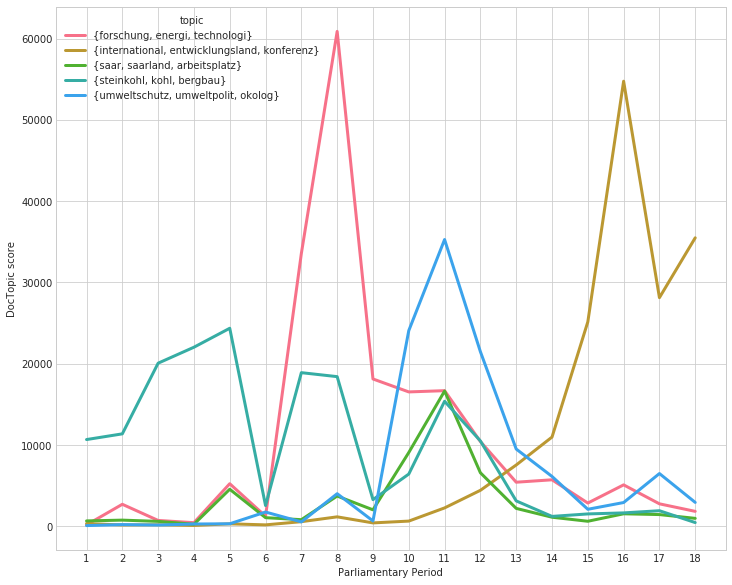

In [13]:
sns.set_palette('husl')

ax = df.plot(figsize=(12,10), xticks = df.index)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score')

fig = plt.gcf()
ax = plt.gca()

plt.show()

fig.savefig('dtopicscore_topic_comparison.png')

---

### Party Analysis

#### one topic

In [18]:
# from parliament/views.py
topic1 = 133077
t1_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic1,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id', 
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

In [19]:
dft1 = pd.DataFrame.from_dict(list(t1_party_totals))
dft1.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft1_n = pd.DataFrame([dft1['parlperiod'], dft1['party_name'], dft1['doctopic_score']]).transpose()
dft1_n = dft1_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

In [20]:
# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)

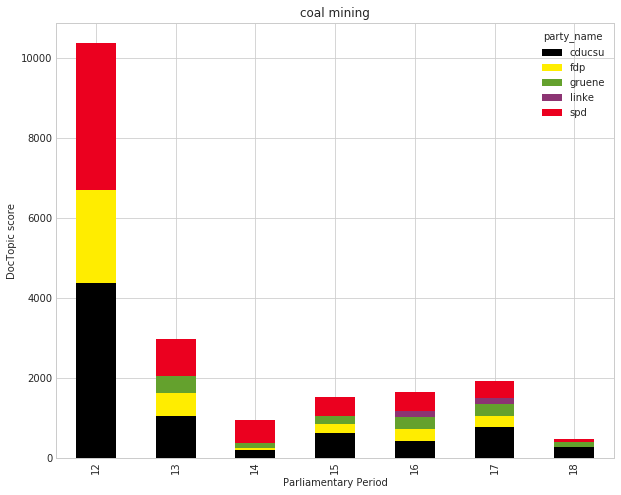

In [22]:
# Stacked bar plot
topic_names =['coal mining']
ax = dft1_n.plot(kind='bar', stacked=True, title=topic_names[0], figsize=(10,8), xticks = dft1_n.index)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score')

fig = plt.gcf()
ax = plt.gca()

plt.show()
fig.savefig('dtopicscore_party_comparison_{}.png'.format(topic1))

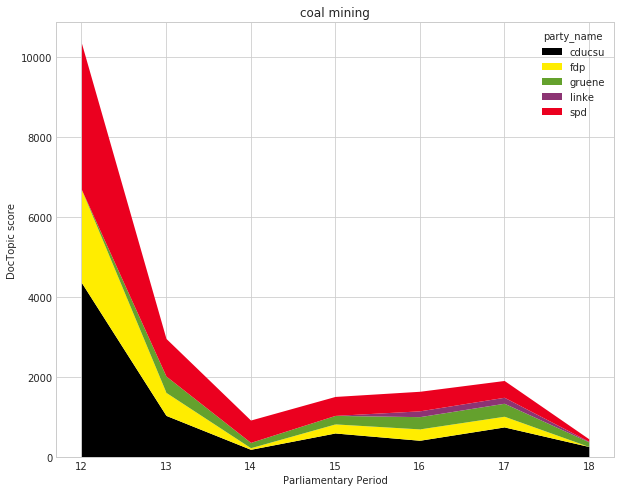

In [23]:
# Stacked area plot
ax = dft1_n.plot.area(figsize=[10,8], linewidth=0)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[0])

plt.show()
fig.savefig('dtopicscore_party_comparison_stack_{}.png'.format(topic1))

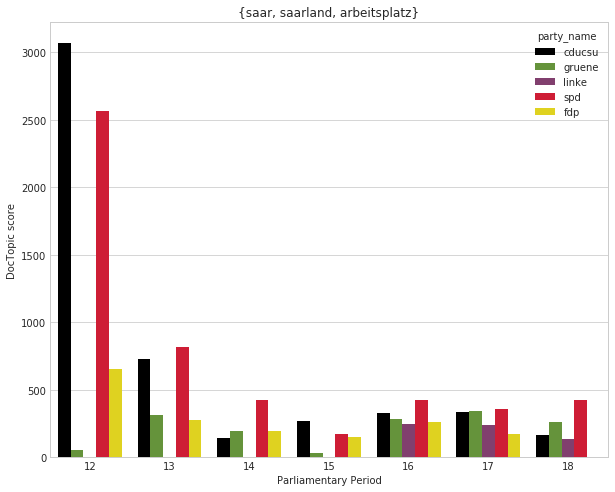

In [283]:
# adding custom colour palette - automatic assignment 
# plot using seaborn barplot 
# problem: can't stack, but can manually edit for stack
dft1_test = pd.DataFrame([dft1['parlperiod'], dft1['party_name'], dft1['doctopic_score']]).transpose()
de_party = dict(cducsu="#000000", gruene="#64A12D", linke="#8C3473", spd="#EB001F", fdp="#FFED00")

fig, ax = plt.subplots(figsize=[10,8])
sns.barplot(data=dft1_test, x ='parlperiod', y='doctopic_score', hue='party_name', palette=de_party)
ax.set(xlabel="Parliamentary Period", ylabel="DocTopic score", title=t1_name)
plt.show()

In [47]:
# why party data only available from pp 12 onwards? 
# inspection of data 
testing = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        #speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic_ids[0],
                     then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'document__parlperiod__n', #parlperiod
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id', 
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('-document__parlperiod__n')

In [48]:
len(testing), len(party_totals[0])

(34, 31)

In [52]:
df_testing = pd.DataFrame.from_dict(list(testing))
# difference in length explained by 'parteilos'

#### multiple topics

In [17]:
topic_ids = [133077, 133073, 133066, 133049, 133063]
party_totals = []
topic_names = []
for i in topic_ids:
    topic_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=i,
                     then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'document__parlperiod__n', #parlperiod
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id', 
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('-document__parlperiod__n')
    
    party_totals.append(list(topic_party_totals))
    
    t_name = Topic.objects.get(id=i).title
    topic_names.append(t_name)


In [15]:
# create data frame from party_totals
dft2 = pd.DataFrame.from_dict(list(party_totals[1]))
dft2.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft2_n = pd.DataFrame([dft2['parlperiod'], dft2['party_name'], dft2['doctopic_score']]).transpose()
dft2_n = dft2_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

dft3 = pd.DataFrame.from_dict(list(party_totals[2]))
dft3.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft3_n = pd.DataFrame([dft3['parlperiod'], dft3['party_name'], dft3['doctopic_score']]).transpose()
dft3_n = dft3_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

dft4 = pd.DataFrame.from_dict(list(party_totals[3]))
dft4.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft4_n = pd.DataFrame([dft4['parlperiod'], dft4['party_name'], dft4['doctopic_score']]).transpose()
dft4_n = dft4_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

dft5 = pd.DataFrame.from_dict(list(party_totals[4]))
dft5.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft5_n = pd.DataFrame([dft5['parlperiod'], dft5['party_name'], dft5['doctopic_score']]).transpose()
dft5_n = dft5_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

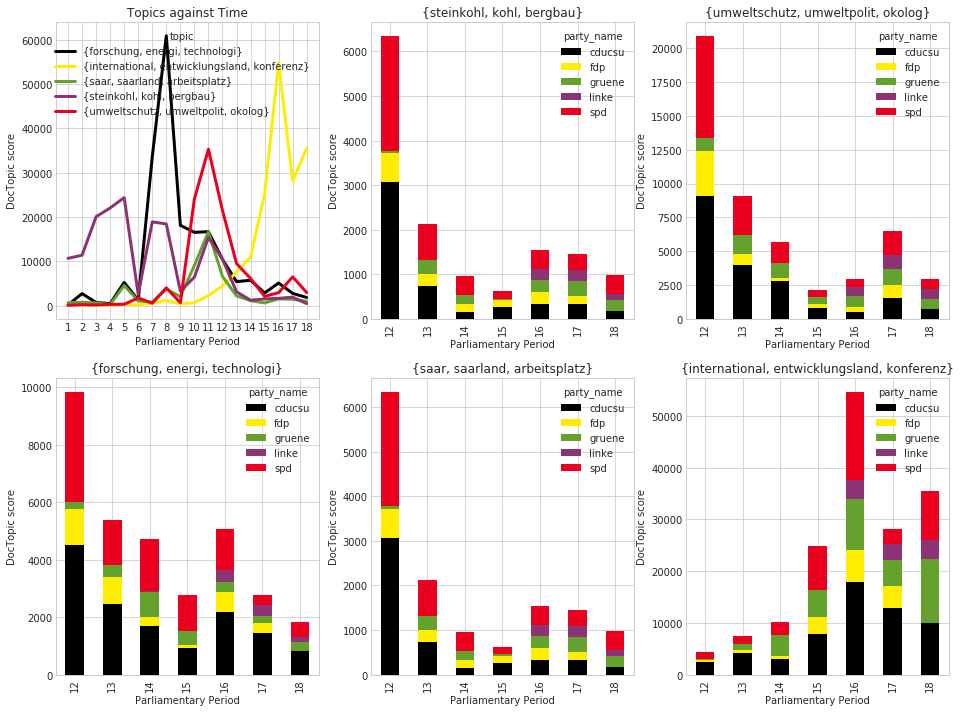

In [25]:
# create multiple plots of topic-time-party plot side by side, stacked bars
fig, ax = plt.subplots(figsize=[16,12], nrows=2, ncols=3)

df.plot(title='Topics against Time', xticks = df.index, ax=ax[0,0])
ax[0,0].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 1
dft1_n.plot(kind='bar', stacked=True, title=topic_names[0], xticks = dft1_n.index, ax=ax[0,1])
ax[0,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 2
dft2_n.plot(kind='bar', stacked=True, title=topic_names[1], xticks = dft1_n.index, ax=ax[0,2])
ax[0,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 3
dft3_n.plot(kind='bar', stacked=True, title=topic_names[2], xticks = dft1_n.index, ax=ax[1,0])
ax[1,0].set(xlabel='Parliamentary Period', ylabel='DocTopic score')                 

# topic 4
dft4_n.plot(kind='bar', stacked=True, title=topic_names[3], xticks = dft1_n.index, ax=ax[1,1])
ax[1,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 5
dft5_n.plot(kind='bar', stacked=True, title=topic_names[4], xticks = dft1_n.index, ax=ax[1,2])
ax[1,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

plt.show()

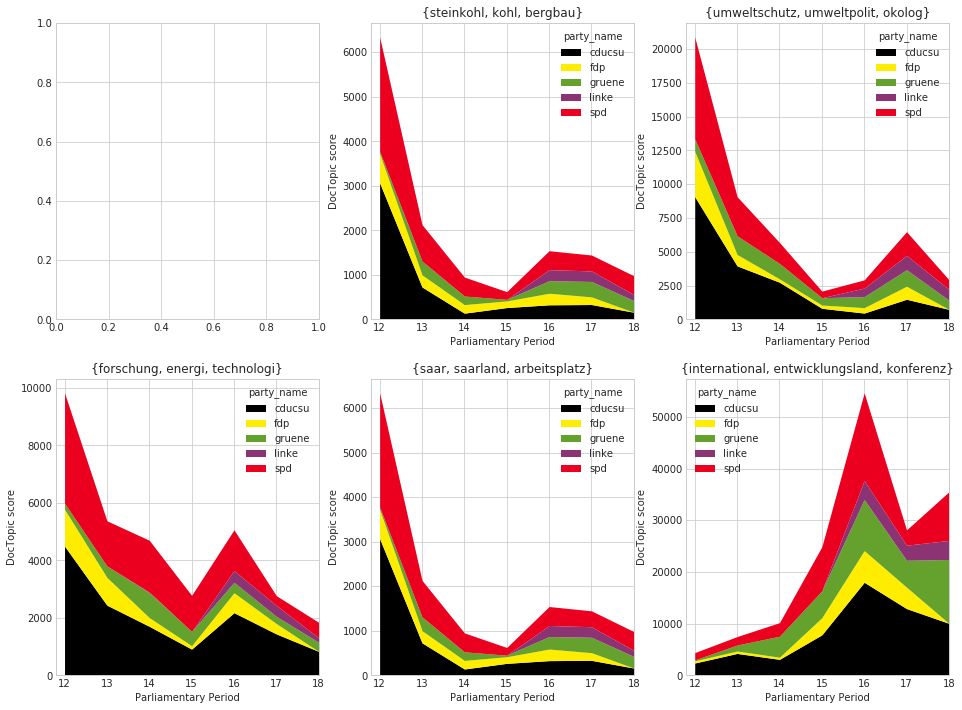

In [43]:
# create multiple plots of topic-time-party plot side by side, stacked area 
fig, ax = plt.subplots(figsize=[16,12], nrows=2, ncols=3)

dft1_n.plot(kind='area', linewidth=0, ax=ax[0,1])
ax[0,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[0], xlim=(11.8,18))

dft2_n.plot(kind='area', linewidth=0, ax=ax[0,2])
ax[0,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[1], xlim=(11.8,18))

dft3_n.plot(kind='area', linewidth=0, ax=ax[1,0])
ax[1,0].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[2], xlim=(11.8,18))

dft4_n.plot(kind='area', linewidth=0, ax=ax[1,1])
ax[1,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[3], xlim=(11.8,18))

dft5_n.plot(kind='area', linewidth=0, ax=ax[1,2])
ax[1,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[4], xlim=(11.8,18))

plt.show()

---

#### new runs, pp 13 to 19

In [177]:
# Dynamic LDA, K=50
run_id2 = 1367
dts2 = DocTopic.objects.filter(run_id=run_id2)

In [209]:
# Topic 2
t1r2 = 157177
t1r2_name = Topic.objects.get(id=t1r2).title
t1r2_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id2, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=t1r2,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id', 
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

In [180]:
dft1r2 = pd.DataFrame.from_dict(list(t1r2_party_totals))
dft1r2.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']

dft1r2_n = pd.DataFrame([dft1r2['parlperiod'], dft1r2['party_name'], dft1r2['doctopic_score']]).transpose()
dft1r2_n = dft1r2_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

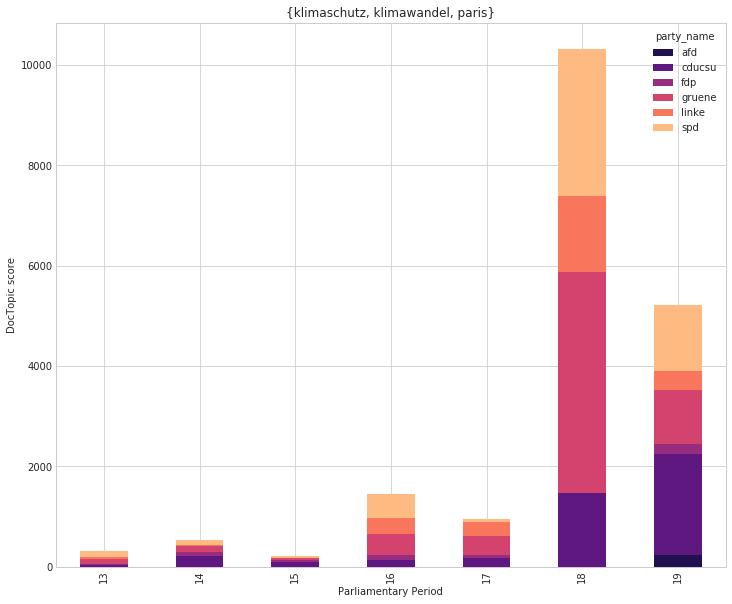

In [211]:
ax = dft1r2_n.plot(kind='bar', stacked=True, title=t1r2_name, figsize=(12,10), xticks = dft1r2_n.index)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score')

fig = plt.gcf()
ax = plt.gca()

plt.show()

In [213]:
# Topic 2
t2r2 = 157203
t2r2_name = Topic.objects.get(id=t2r2).title
t2r2_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id2, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=t2r2,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id', 
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

In [214]:
dft2r2 = pd.DataFrame.from_dict(list(t2r2_party_totals))
dft2r2.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft2r2_n = pd.DataFrame([dft2r2['parlperiod'], dft2r2['party_name'], dft2r2['doctopic_score']]).transpose()
dft2r2_n = dft2r2_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

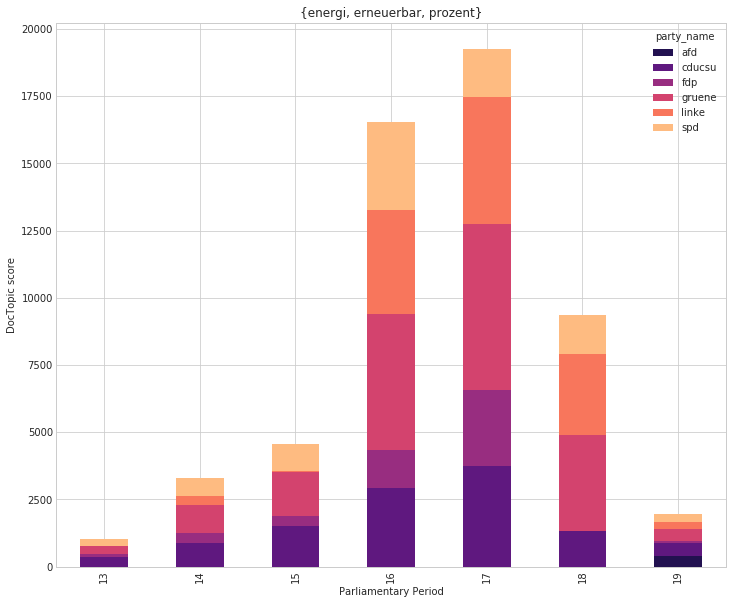

In [215]:
ax = dft2r2_n.plot(kind='bar', stacked=True, title=t2r2_name, figsize=(12,10), xticks = dft2r2_n.index)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score')

fig = plt.gcf()
ax = plt.gca()

plt.show()